## Using the Cityscape Dataset downloaded from Kaggle to train a Segmentation Model

In [1]:
# Fist connect google drive with colab
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np 
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,UpSampling2D,Concatenate,Input,Softmax
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint

Set Parameters

In [3]:
EPOCHS=10
BATCH_SIZE=10
HEIGHT=256
WIDTH=256
N_CLASSES=13

In [4]:
def load_image(dpath, fname):
  '''
  function to split the kaggle images to the 
  input image and the corresponding mask

  Args:
    dpath: the path where the images are
    fname: the name of the image

  Return:
    im: the input image
    mask: the corresponding output
  '''

  image = Image.open(os.path.join(dpath, fname))
  image = np.array(image)
  size = image.shape
  im = image[:,:size[1]//2]
  mask = image[:,size[1]//2:]
  return im, mask

def bin_mask(mask):
  '''
  #############################
  Funktion genauer angucken
  #############################
  '''
  bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
  new_mask = np.digitize(mask, bins)
  return new_mask

def getSegmentationArr(image, classes, width= WIDTH, height= HEIGHT):
  '''
  Create a Mask for every class. Creating an array or Dim (height, width, classes)
  Every channel will contain only one class

  Args:
    image:
    classes:
    width:
    height:

  Returns:
    seg_labels: Numpy array, with "classes" channel, where every channel contain only 1 or 0
  '''

  seg_labels = np.zeros((height, width, classes)) # Create a Numpy label corresponding to the mask/image size
  img = image[:,:,0] # get one channel of the image

  for c in range(classes):
    seg_labels[:, :, c] = (img == c).astype(int) # Iterate over all classes. if the image contains the class, it will be saved in a seperate CLASS CHANNEL
  
  return seg_labels

def give_color_to_seg_img(seg, n_classes=N_CLASSES):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    print(seg_img.shape)
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return seg_img


In [5]:
image, mask = load_image("/content/gdrive/MyDrive/Dataset/cityscapes_data/cityscapes_data/train/","1.jpg")
print(image.shape, mask.shape)

test = getSegmentationArr(mask, classes=13)
print(test.shape)

(256, 256, 3) (256, 256, 3)
(256, 256, 13)


## Dataset

In [6]:
train_folder = "/content/gdrive/MyDrive/Dataset/cityscapes_data/train"
valid_folder = "/content/gdrive/MyDrive/Dataset/cityscapes_data/val"

num_of_training_samples = len(os.listdir(train_folder))
num_of_valid_samples = len(os.listdir(valid_folder))

print(f"Num of Training samples: {num_of_training_samples}")
print(f"Num of Validation samples: {num_of_valid_samples}")

def DataGenerator(path, batch_size=BATCH_SIZE, classes=N_CLASSES):
  '''
  '''

  files = os.listdir(path)
  while True:
    for i in range(0, len(files), batch_size):   # from 0 - len(files) using batch size as steps
      batch_files = files[i : i + batch_size] # Fill the batch files with "batch_size" images
      imgs = list()
      segs = list()
      for file in batch_files:
        image, mask = load_image(path, file)
        mask_binned = bin_mask(mask)
        labels = getSegmentationArr(mask_binned, classes)

        imgs.append(image)
        segs.append(labels)
      yield np.array(imgs), np.array(segs) # With yield you return Generators, which can be iterated over ONCE and don't need all the space, because data is used "on the fly"
                                          
      

Num of Training samples: 2975
Num of Validation samples: 500


In [7]:
train_gen = DataGenerator(train_folder, batch_size=BATCH_SIZE)
val_gen = DataGenerator(valid_folder, batch_size=BATCH_SIZE)
print(train_gen)

<generator object DataGenerator at 0x7f29fc2e4f50>


In [8]:
### Check if the batches are given the way we want it
imgs, segs = next(train_gen)

print(f"Shape of Training Batch: Image: {imgs.shape}, Label: {segs.shape}")

Shape of Training Batch: Image: (10, 256, 256, 3), Label: (10, 256, 256, 13)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)


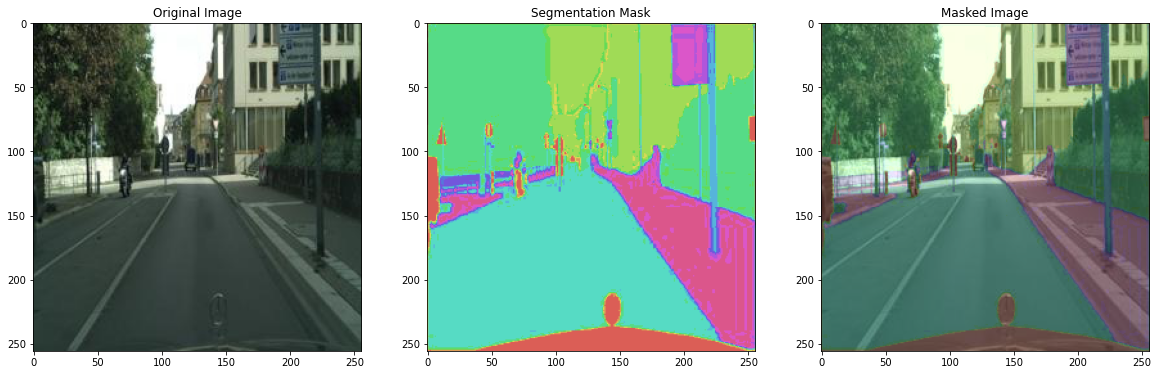

In [9]:
image = imgs[5]
mask = give_color_to_seg_img(np.argmax(segs[5], axis=-1))
print(mask.shape)
masked_image = cv2.addWeighted(image/255, 0.8, mask, 0.3, 0)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
#predimg = cv2.addWeighted(imgs[i]/255, 0.6, _p, 0.4, 0)
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plt.show()

## Define a Model

In [25]:
class UNet(Model):
  def __init__(self):
    super(UNet).__init__()
    print()



class DownBlock(Model):
  def __init__(self, filters, kernel_size=(3, 3), padding='same', strides=1):
    super().__init__()
    self.filters = filters
    self.kernel_size = kernel_size
    self.padding = padding
    self.strides = strides


  def call(self, x):
    c = Conv2D(self.filters, self.kernel_size, padding=self.padding, strides=self.strides)(x)
    c = Conv2D(self.filters, self.kernel_size, padding=self.padding, strides=self.strides)(c)
    p = MaxPool2D((2, 2), (2, 2))(c)

    return x, p  #Return the downsampled image and the original resolution for the skip connections

class UpBlock(Model):
  def __init__(self, filters, kernel_size=(3, 3), padding='same', strides=1):
    super().__init__()
    self.filters = filters
    self.kernel_size = kernel_size 
    self.padding = padding 
    self.strides = strides

  def call(self, x, skip):
    

down = DownBlock(128)

ori, down = down(imgs.astype('float32'))

### Test Downblock
print(f"Shape after two Convs: {ori.shape}, Shape after Maxpool: {down.shape}")



Shape after two Convs: (10, 256, 256, 3), Shape after Maxpool: (10, 128, 128, 128)
